Apogee (Max Height): 1042.93 m
Range (Total horizontal distance traveled): 288.10 m


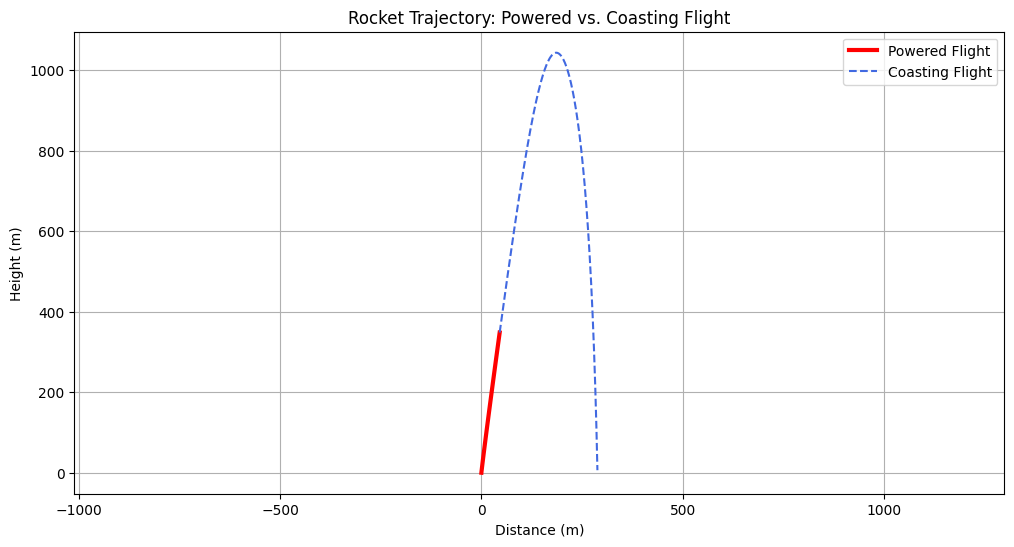

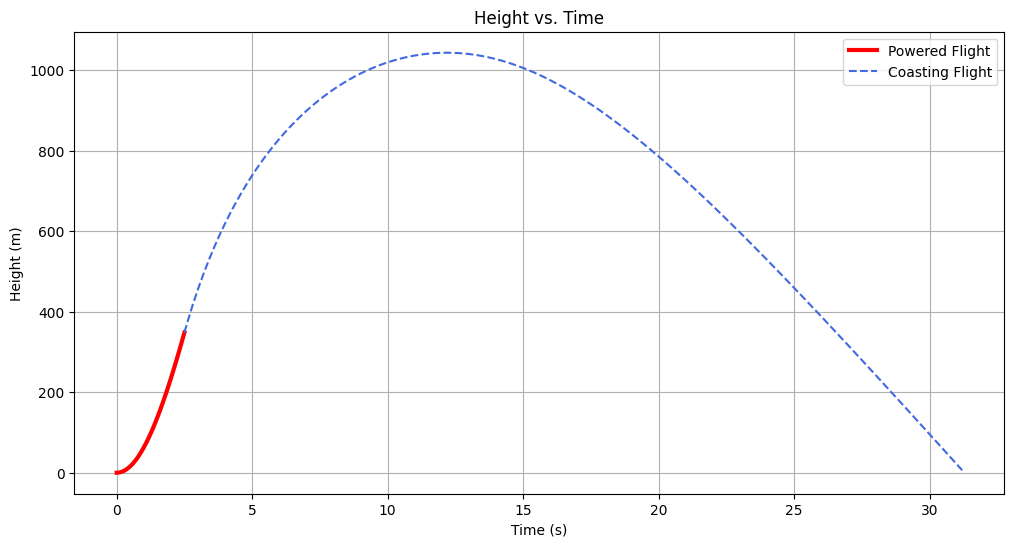

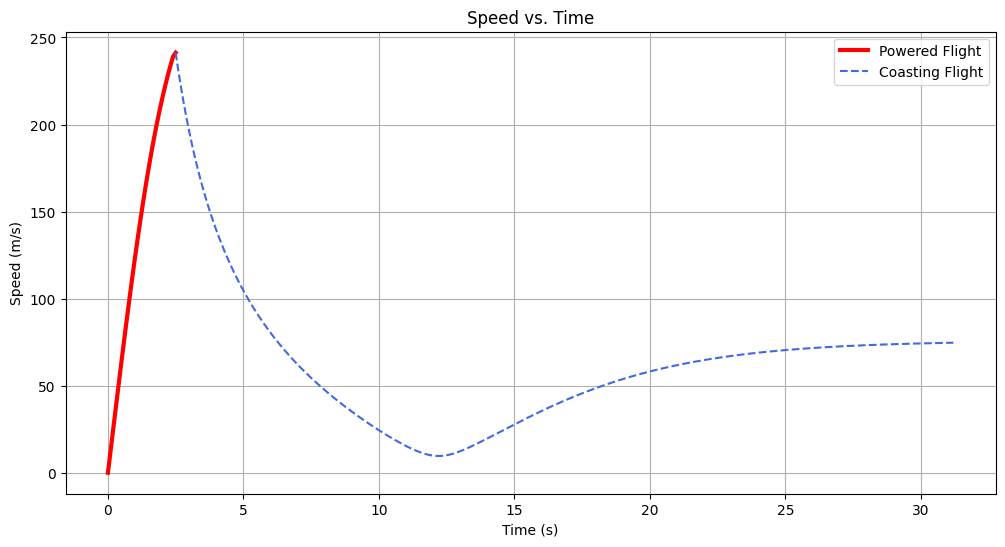

In [16]:
# Estimate the 2D trajectory of a rocket using a 4th order Runge-Kutta method.
#   Forces considered:
#     - Thrust
#     - Gravity
#     - Quadratic drag.
#   Assumptions made:
#     - Constant gravitational force
#     - Constant air density
#     - Constant thrust
#     - Non-rotating earth and level ground
#     - Zero angle of attack
#     - Zero lift.
# Purdue University Northwest - PHYS 30800 Scientific Computation I - Professor Dolen

import numpy as np
import matplotlib.pyplot as plt


def calculate_acceleration(state_vector: np.ndarray, params: dict, current_time: float, current_mass: float) -> np.ndarray:
    """
    Calculates the current acceleration based on the forces acting on the rocket.

    Forces considered: Thrust, Gravity, and Quadratic Air Drag.
    Applies Newton's Second Law (a = F/m) using the rocket's current mass.

    Args:
        state_vector (np.ndarray): The current state of the rocket [x, y, vx, vy].
        params (dict): A dictionary of all physical constants.
        current_time (float): The simulation time, used to check if the motor is firing.
        current_mass (float): The rocket's current mass, which changes during the burn.

    Returns:
        np.ndarray: An array of derivatives [dx/dt, dy/dt, dvx/dt, dvy/dt]
         which tell us how the state vector will change
           (vx=dx/dt tells how the x-position will change in some small time step)
           (vy=dy/dt tells how the y-position will change in some small time step)
           (ax=dvx/dt tells how the x-component of velocity will change in some small time step)
           (ay=dvy/dt tells how the y-component of velocity will change in some small time step)
    """

    # Unpack parameters and state vector for clarity
    g, rho, C_D, A = params['g'], params['rho'], params['C_D'], params['A']
    x, y, vx, vy = state_vector

    # Calculate the current speed (magnitude of velocity)
    speed = np.sqrt(vx**2 + vy**2) # [m/s]

    # The thrust and the drag forces both depend on our current velocity direction
    # Here we calculate the unit vector components
    #   (the unit vector has a length of 1 and only represents direction)
    if speed > 0:
        # Define the components of the unit vector for the velocity direction
        #   based on the current velocity components and the speed
        unit_vec_x = vx / speed
        unit_vec_y = vy / speed
    else:
        # If stationary (at t=0), thrust acts along the initial launch angle
        launch_angle = params['launch_angle_rad']
        unit_vec_x = np.cos(launch_angle)
        unit_vec_y = np.sin(launch_angle)

    #-----Calculate the Gravitational Force-----#
    #  We define up to be the positive  y direction.
    #  Gravity always acts straight down in the negative y direction
    #  The gravitational force depends on the rocket's current mass.
    force_gravity_y = -current_mass * g

    #-----Calculate the Thrust-----#

    # Ensure there is only a thrust force during the burn time
    thrust_magnitude = 0.0
    if current_time < params['burn_time']:
        thrust_magnitude = params['thrust_force']

    # Determine the direction of thrust (in the direction the rocket is moving)
    force_thrust_x = thrust_magnitude * unit_vec_x
    force_thrust_y = thrust_magnitude * unit_vec_y

    #-----Calculate the Quadratic Drag Force-----#

    # Calculate the drag force magntiude (Newtons)
    force_drag_magnitude = 0.5 * rho * C_D * A * speed**2

    # Calculate the components of the drag force vector
    #   The drag direction is always opposite the current velocity vector
    force_drag_x = -force_drag_magnitude * unit_vec_x
    force_drag_y = -force_drag_magnitude * unit_vec_y

    #-----Calculate the Total Force-----#
    total_force_x = force_thrust_x + force_drag_x
    total_force_y = force_thrust_y + force_drag_y + force_gravity_y

    #-----Calculate the Acceleration using Newton (a = F/m)-----#
    ax = total_force_x / current_mass
    ay = total_force_y / current_mass

    #-----Return the array which tells the state vectors how to change-----#
    return np.array([vx, vy, ax, ay], float) #[dx/dt, dy/dt, dvx/dt, dvy/dt]


def run_simulation(initial_state: np.ndarray, dt: float, params: dict) -> tuple:
    """
    Runs the simulation using the 4th-order Runge-Kutta (RK4) method.

    Args:
        initial_state (np.ndarray): The initial state of the rocket [x, y, vx, vy].
        dt (float): The time step for the simulation.
        params (dict): A dictionary of all physical constants.

    Returns:
        tuple: A tuple containing the lists of time, x_pos, y_pos, vx, vy.
    """
    state_vector = np.array(initial_state, dtype=float)
    time = 0.0

    # Create empty lists to track each time step
    #  and the position and velocity vector components at each step
    history_t, history_x, history_y, history_vx, history_vy = [], [], [], [], []


    # Loop while the rocket is in the air (state_vector[1] = current y-position)
    while state_vector[1] >= 0.0:
        history_t.append(time)
        history_x.append(state_vector[0])
        history_y.append(state_vector[1])
        history_vx.append(state_vector[2])
        history_vy.append(state_vector[3])

        # --- Update the rocket's mass for this time step ---
        # (assume mass is constant over small interval dt)
        if time < params['burn_time']:
            mass_lost = params['mass_flow_rate'] * time
            current_mass = params['initial_total_mass'] - mass_lost
        else:
            current_mass = params['dry_mass']

        # --- Perform Runge-Kutta (RK4) Step ---
        #   Here for each time step we know how position and velocity change
        #     because we know the current velocity and acceleration
        #       RK4 just does this with more accuracy then simpler methods
        k1 = dt * calculate_acceleration(state_vector, params, time, current_mass)
        k2 = dt * calculate_acceleration(state_vector + 0.5 * k1, params, time + 0.5*dt, current_mass)
        k3 = dt * calculate_acceleration(state_vector + 0.5 * k2, params, time + 0.5*dt, current_mass)
        k4 = dt * calculate_acceleration(state_vector + k3, params, time + dt, current_mass)
        state_vector += (k1 + 2*k2 + 2*k3 + k4) / 6
        time += dt

    return history_t, history_x, history_y, history_vx, history_vy

# Main is used to change parameters and run the script.
if __name__ == "__main__":

    #------These are paremeters you can experiment with------#

    # Rocket properties
    rocket_diameter = 0.05  # Diameter of the rocket body in meters
    dry_mass = 0.5          # Mass of the rocket without propellant [kg]
    drag_coefficient = 0.71 # This is estimated. Need to look up for specific rocket.
    cross_sectional_area = np.pi * (rocket_diameter / 2)**2 # [m^2]

    # Motor properties
    thrust_force = 80.0     # Average thrust in Newtons
    burn_time = 2.5         # Motor burn time in seconds
    propellant_mass = 0.080 # Mass of the propellant in kg

    # Calculate initial total mass and mass flow rate
    initial_total_mass = dry_mass + propellant_mass
    mass_flow_rate = propellant_mass / burn_time

    # Constants
    GRAVITATIONAL_ACCELERATION = 9.81   # Standard gravity on Earth's surface [m/s^2]
    AIR_DENSITY_SEA_LEVEL = 1.225       # Air density at sea level and 15°C [kg/m^3]

    # Initial flight conditions
    initial_x_position = 0.0 # Initial height [m]
    initial_y_position = 0.0 # Initial height [m]
    initial_speed = 0.0      # Initial speed [m/s]
    theta_deg = 85.0   # Launch angle [degrees] as measured from the horizontal (90 is straight up)
    theta_rad = np.deg2rad(theta_deg) # Convert launch angle to radians

    # The time step (dt) determines the accuracy of the simulation (smaller is more accurate but slower)
    delta_t = 0.1  # Time step [s]

    #-------------------------------------------------------------#

    # Create a Python Dictionary storing physical parameters so we can send them all to the functions at once
    #   How a dictionary works: For each key there is a stored value
    #      For example, the key 'g' stores 9.81,
    #         so i can access this with PHYSICAL_PARAMS['g']=9.81
    PHYSICAL_PARAMS = {
        'g': GRAVITATIONAL_ACCELERATION,
        'rho': AIR_DENSITY_SEA_LEVEL,
        'C_D': drag_coefficient,
        'A': cross_sectional_area,
        'thrust_force': thrust_force,
        'burn_time': burn_time,
        'dry_mass': dry_mass,
        'initial_total_mass': initial_total_mass,
        'mass_flow_rate': mass_flow_rate,
        'launch_angle_rad': theta_rad
    }

    # Create the initial state vector [x_pos, y_pos, x_velocity, y_velocity]
    #   We will use this to track the position and velocity vectors after each time step
    initial_state_vector = [
        initial_x_position,     # Initial x-position
        initial_y_position,     # Initial y-position
        initial_speed * np.cos(theta_rad), #Initial x-component of velocity
        initial_speed * np.sin(theta_rad)  #Initial y-component of velocity
    ]

    #-----Run the simulation-----#
    #  run_simulation() returns a tuple with the full results
    #     Here we unpack the tuple to create five lists: time, x_pos, y_pos, vx, vy
    #       These contain the position and velocities of the rocket at every time step
    time, x_pos, y_pos, vx, vy = run_simulation(
        initial_state=initial_state_vector,
        dt=delta_t,
        params=PHYSICAL_PARAMS
    )

    #-----Print some post-simulation results-----#
    apogee = max(y_pos) # maximum height (apogee) in meters
    print(f"Apogee (Max Height): {apogee:.2f} m")
    print(f"Range (Total horizontal distance traveled): {x_pos[-1]:.2f} m") # [-1] selects the last element of the list

    #-----Plot the motion-----#

    # Split the trajectory data into powered and coasting phases

    # Find the index for when the motor burns out
    burn_time = PHYSICAL_PARAMS['burn_time']
    try:
        # Find the first time step that is after the burn_time
        burnout_index = len(time) # Default to the end if not found

        # Loop through the time data with indices
        for i, t in enumerate(time):
            # Check if the current time is past the burnout time
            if t > burn_time:
                # If it is, we've found our index!
                burnout_index = i
                # Stop the loop immediately since we only need the first one
                break
    except StopIteration:
        # If the simulation ends before burnout, plot the whole thing as powered
        burnout_index = len(time)

    # Select from the first time step to the end of the burn
    x_powered = x_pos[:burnout_index + 1]
    y_powered = y_pos[:burnout_index + 1]
    # Select from the end of the burn to the rocket hits the ground (have one overlap index so the lines match)
    x_coast = x_pos[burnout_index:]
    y_coast = y_pos[burnout_index:]

    # Plot Trajectory (x,y) = (height,distance)
    plt.figure(figsize=(12, 6))
    plt.plot(x_powered, y_powered, color='red', linewidth=3, label='Powered Flight')
    plt.plot(x_coast, y_coast, color='royalblue', linestyle='--', label='Coasting Flight')
    plt.title('Rocket Trajectory: Powered vs. Coasting Flight')
    plt.xlabel('Distance (m)')
    plt.ylabel('Height (m)')
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.show()


    # Plot the Height vs time
    plt.figure(figsize=(12, 6))
    plt.plot(time[:burnout_index+1], y_pos[:burnout_index+1], color='red', linewidth=3, label='Powered Flight')
    plt.plot(time[burnout_index:], y_pos[burnout_index:], color='royalblue', linestyle='--', label='Coasting Flight')
    plt.title('Height vs. Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Height (m)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot the speed vs time
    speed = [np.sqrt(ivx**2 + ivy**2) for ivx, ivy in zip(vx, vy)]
    plt.figure(figsize=(12, 6))
    plt.plot(time[:burnout_index+1], speed[:burnout_index+1], color='red', linewidth=3, label='Powered Flight')
    plt.plot(time[burnout_index:], speed[burnout_index:], color='royalblue', linestyle='--', label='Coasting Flight')
    plt.title('Speed vs. Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (m/s)')
    plt.grid(True)
    plt.legend()
    plt.show()

